In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import dvu
import seaborn as sns
import os
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from os.path import join
import numpy as np
import imodelsx.process_results
import ridge_utils.features.qa_questions as qa_questions
import joblib
from tqdm import tqdm
import analyze_helper
import viz
fit_encoding = __import__('02_fit_encoding')
dvu.set_style()

results_dir = '/home/chansingh/mntv1/deep-fMRI/encoding/results_apr7'
r, cols_varied, mets = analyze_helper.load_clean_results(results_dir)
r = r[r.feature_selection_alpha_index < 0]
r = r[r.distill_model_path.isna()]
r = r[~(r.feature_space == 'qa_embedder-25')]
r = r[r.pc_components == 100]

metric_sort = 'corrs_tune_pc_mean'
r = analyze_helper.add_corrs_tune_pc_weighted(r)
metric_sort = 'corrs_tune_pc_weighted_mean'
mets.append(metric_sort)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 390/390 [01:05<00:00,  5.91it/s]


experiment varied these params: ['subject', 'pc_components', 'distill_model_path', 'feature_space', 'feature_selection_alpha_index', 'qa_embedding_model', 'qa_questions_version', 'ndelays', 'seed']


In [ ]:
# imodelsx.process_results.delete_runs_in_dataframe(
#     r[r.seed != 1], actually_delete=True)

### best results breakdown

feature_space_simplified,bert-10,eng1000,finetune_roberta-base-10,finetune_roberta-base_binary-10,llama,qa_embedder-10
subject,,,,,,
S01,0.080,0.067,0.080,0.082,0.093,0.085
S02,0.114,0.092,0.118,0.118,0.131,0.121
S03,0.136,0.116,0.136,0.141,0.153,0.135
AVG,0.110,0.092,0.111,0.114,0.125,0.114


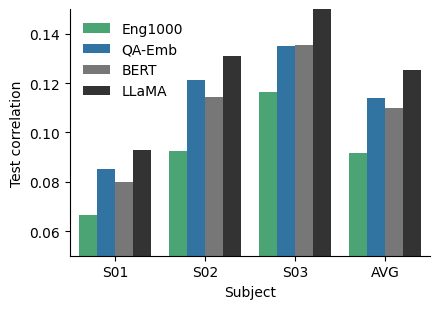

In [ ]:
r['feature_space_simplified'] = r['feature_space'].apply(
    lambda x: 'llama' if 'llama' in x else x
)
d = r
# d = d[~((d.feature_space == 'qa_embedder-10') & (d.ndelays != 8))]
d = d[~((d.feature_space.str.contains('llama')) & (d.ndelays != 4))]
d = d[d.pc_components == 100]

d = d.sort_values(
    by=metric_sort, ascending=False)
d = d.groupby(['subject', 'feature_space_simplified'])[mets]
d = d.first().reset_index()
# display(d)
tab = d.pivot_table(index='subject', columns='feature_space_simplified',
                    values='corrs_test_mean', aggfunc='mean')
# d.pivot_table(index='subject', columns='feature_space_simplified',
#                     values='corrs_test_mean_sem', aggfunc='mean')

# # add average row
tab.loc['AVG'] = tab.mean()
display(tab.round(3))

tab['Subject'] = tab.index.str.replace('UT', '')
# rename stuf
tab.columns = tab.columns.map(lambda x: {
    'bert-10': 'BERT',
    'eng1000': 'Eng1000',
    'llama': 'LLaMA',
    'qa_embedder-10': 'QA-Emb',
    'finetune_roberta-base-10': 'QA-Emb (distill logits)',
    'finetune_roberta-base_binary-10': 'QA-Emb (distill)',
}.get(x, x))

plot_data = tab.melt(id_vars='Subject',
                     var_name='feature_space_simplified', value_name='corrs_test_mean')
# fig, ax = plt.subplots(figsize=(4, 3))
plt.figure(figsize=(4.5, 3.2))
sns.barplot(
    plot_data, x='Subject', y='corrs_test_mean',
    hue='feature_space_simplified',
    hue_order=[
        'Eng1000', 'QA-Emb', 'BERT', 'LLaMA'],
    palette=['mediumseagreen', 'C0', '#777', '#333'])  # blues: '#52aae7', 'C0', '#004481'
# move legend outside
plt.legend(loc='upper left', frameon=False)  # , bbox_to_anchor=(0.75, 1.2))
plt.ylabel('Test correlation')
plt.ylim((0.05, 0.15))
plt.tight_layout()
plt.savefig('../figs/corr_best.pdf', bbox_inches='tight')
plt.show()

In [ ]:
t = tab.round(3)[['QA-Emb', 'QA-Emb (distill)',
                  'QA-Emb (distill logits)', 'Eng1000']].astype(str)
# bold the bottom row
t.loc['AVG'] = t.loc['AVG'].apply(lambda x: f'\\textbf{{{x}}}')
# bold AVG index label
t = t.rename(index={'AVG': '\\textbf{AVG}'})
# delete the column label name
t.columns.name = None
t.index.name = None

# export to latex using booktabs
print(t.to_latex(escape=False, column_format='lrrrr', float_format='%.3f'))

### qa version breakdowns

In [ ]:
d = r[(r.feature_space == 'qa_embedder-10') * (r.pc_components == 100)]
# d = r[(r.pc_components == 100)]
d = d[d.ndelays == 8]
d = d[~d.qa_embedding_model.str.contains('mixt')]
d['qa_questions_version'] = d['qa_questions_version'].apply(
    viz.version_rename)
cols = ['subject', 'qa_questions_version', 'qa_embedding_model']
d = d.groupby(cols)[mets].mean()
d = (
    d.pivot_table(index=[c for c in cols if not c == 'qa_embedding_model'],
                  columns='qa_embedding_model', values='corrs_test_mean', aggfunc='mean')
)
# add average row to multiindex
for qa_questions_version in sorted(d.index.get_level_values('qa_questions_version').unique()):
    dn = d.loc[(slice(None), qa_questions_version), :]
    d.loc[('AVG', qa_questions_version), :] = dn.mean()
display(
    d
    .style.background_gradient(cmap='magma')  # , axis=0)
    .format(precision=3)
)

# d = d.drop(columns='llama3-8B-refined')
# d.columns.name = None
# d.index.names = ['Subject', 'Questions']
# d.columns = d.columns.map(viz.feature_space_rename)
# d = d.loc[(slice(None), ['Prompts 1-3 (376 questions)',
#            'Prompts 1-5 (518 questions)', 'Prompts 1-6 (674 questions)']), :]
# print(d.to_latex(escape=False, float_format='%.3f'))A

In [ ]:
d = r[(~r.feature_space.str.contains('qa_embedder')) * (r.pc_components == 100)]
d = d[(~d.feature_space.str.contains('roberta'))]
# d = r[(r.pc_components == 100)]
# d = d[d.ndelays == 8]
cols = ['subject', 'ndelays', 'feature_space']
d = d.groupby(cols)[mets].mean()
d = (
    d.pivot_table(index=[c for c in cols if not c == 'feature_space'],
                  columns='feature_space', values='corrs_test_mean', aggfunc='mean')
    .rename(columns=viz.feature_space_rename)
    # sort columns alphabetically
    .sort_index(axis=1)
)
# add average row to multiindex
for ndelays in sorted(d.index.get_level_values('ndelays').unique()):
    dn = d.loc[(slice(None), ndelays), :]
    d.loc[('AVG', ndelays), :] = dn.mean()


d.columns.name = None
d.index.names = ['Subject', 'Delays']
display(d
        .style.background_gradient(cmap='magma')  # , axis=0)
        .format(precision=3)
        )
print(d.T.to_latex(escape=False, float_format='%.3f'))

### look at all results

In [ ]:
d = r
# d = d[d.feature_space == 'eng1000']
# d = d[d.subject == 'UTS01']
# d = d[~(d.feature_space == 'qa_embedder-10') | (d.ndelays == 8)]
d = d[d.feature_space == 'llama']
cols_varied = [c for c in cols_varied if not c in [
    'distill_model_path', 'feature_selection_alpha_index']]
# d = d[(d.qa_questions_version == 'v1') *
#   (d.qa_embedding_model == 'mistral 7B')]
if len(cols_varied) > 0:
    d = d.groupby(cols_varied)[mets].mean()
else:
    d = d[mets]

(
    d
    # .sort_values(by='corrs_test_mean', ascending=False)
    .sort_values(by=metric_sort, ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='magma', axis=0)
    .format(precision=3)
)

In [ ]:
# # look at distill_model_path
# d = r[(r.feature_space == 'qa_embedder-10') * (r.pc_components == 100)]
# d = d.groupby(cols_varied)[mets].mean()
# d.pivot_table(index=[c for c in cols_varied if not c == 'distill_model_path'],
#               columns='distill_model_path', values='corrs_test_mean', aggfunc='mean')

# Compare performance of a few different models

In [ ]:
# qa = r[(r.feature_space == 'qa_embedder-5')
# ].sort_values(by='corrs_tune_pc_mean', ascending=False).iloc[0]
qa = r.iloc[0]
eng1000 = r[(r.feature_space == 'eng1000')].sort_values(
    by='corrs_tune_pc_mean', ascending=False).iloc[0]

In [ ]:
plt.plot(qa['corrs_test'], eng1000['corrs_test'], '.', ms=1)
plt.xlabel(f'QA Embedder (mean: {qa["corrs_test"].mean():0.3f})')
plt.ylabel(f'Eng1000 (mean: {eng1000["corrs_test"].mean():0.3f})')
plt.title('Test Correlations')
m_max = max(qa['corrs_test'].max(), eng1000['corrs_test'].max())
m_min = min(qa['corrs_test'].min(), eng1000['corrs_test'].min())
plt.plot([m_min, m_max], [m_min, m_max], 'k--')
plt.show()

### Check parameters for rerunning expts (alphas, delays)

In [ ]:
args = r[(r.pc_components == -1) * (r.ndelays == 8)].iloc[0]
args = r.sort_values(by='corrs_test_mean').iloc[-1]
model_params_to_save = joblib.load(
    join(args.save_dir_unique, 'model_params.pkl'))
print(args.feature_space, args.pc_components, args.ndelays)

In [ ]:
# print which alphas are being used
pd.Series(model_params_to_save['alphas_best']).value_counts()

### Hybrid models (use pc_components == 1 when it predicts better)

In [ ]:
args = r[(r.pc_components == -1) * (r.feature_space == 'qa_embedder-5')
         ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]
args2 = r[(r.pc_components > 0) * (r.feature_space == 'qa_embedder-5')
          ].sort_values(by='corrs_tune_mean', ascending=False).iloc[0]
# args = r[]

# args2 = r[(r.feature_space == 'eng1000')].iloc[0]
# args = r[(r.pc_components == -1) * (r.feature_space == 8)].iloc[0]
# args = r[(r.pc_components == -1) * (r.ndelays == 8)].iloc[0]
# model_params_to_save = joblib.load(
# join(args.save_dir_unique, 'model_params.pkl'))

In [ ]:
percentile_thresholds = np.arange(0, 100, 1)
corrs_tune_individual = args['corrs_tune']
corrs_test_individual = args['corrs_test']
corrs_test_pca = args2['corrs_test']
res = []
for percentile_threshold in percentile_thresholds:
    args_top_thresh = np.where(corrs_tune_individual > np.percentile(
        corrs_tune_individual, percentile_threshold))[0]
    args_non_top_thresh = np.where(corrs_tune_individual <= np.percentile(
        corrs_tune_individual, percentile_threshold))[0]
    args_total = np.concatenate([args_top_thresh, args_non_top_thresh])
    mean_corr_weighted = (corrs_test_individual[args_top_thresh].mean() * args_top_thresh.size +
                          corrs_test_pca[args_non_top_thresh].mean() * args_non_top_thresh.size) / args_total.size
    # print('mean corr weighted',
    #       (corrs_test_individual[args_top_thresh].mean() * args_top_thresh.size +
    #        corrs_test_pca[args_non_top_thresh].mean() * args_non_top_thresh.size) / args_total.size
    #       )
    res.append(mean_corr_weighted)
plt.plot(percentile_thresholds, res)
plt.axhline(corrs_test_individual.mean(), color='k', linestyle='--')
plt.axhline(corrs_test_pca.mean(), color='r', linestyle='--')
plt.show()